# Sex prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import umap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation
from utilities import nested_ROC_plot


/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

In [47]:
colors = sn.color_palette("Set2") 

In [32]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldataset.dat", sep='\t')

In [33]:
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [34]:
tsetse_data_copy = tsetse_data.copy()

In [55]:
df_ic = pd.DataFrame(tsetse_data_copy.groupby(['Sex','Age','Tissue'])['ID'].count())
df_ic

ID
Sex Age Tissue                    
f   3d  Abdomen                 48
        Head                   133
        Thorax                 136
        ThoraxAbdomen20230206    1
    5w  Abdomen                 16
        Head                    92
        Thorax                  96
    7w  Abdomen                 38
        Head                   120
        Thorax                 122
m   5w  Head                    94
        Thorax                  93
    7w  Abdomen                 15
        Head                    93
        Thorax                  92

In [56]:
df_ic.to_excel("../results/tables/samples_summary.xlsx")

In [35]:
tsetse_data_sameages = tsetse_data[(tsetse_data["Age"]!= '3d')]
tsetse_data_sameages_copy = tsetse_data_sameages.copy()

In [36]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF_sameage = tsetse_data_sameages_copy[dList]
tsetse_data_sameages_copy.drop(dList, axis=1,inplace=True)

In [37]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF = tsetse_data[dList]
tsetse_data.drop(dList, axis=1,inplace=True)

wnLabels= tsetse_data.columns.values.tolist() #wavenumbers labels
waveNums = [int(x) for x in wnLabels] #wavenumbers numbers (for plotting)

## Clustering

In [39]:
tsetse_females = tsetse_data.loc[(descriptorsDF['Sex'] == 'f')]
tsetse_males = tsetse_data[(descriptorsDF['Sex'] == 'm')]

tsetse_head = tsetse_data_sameages_copy[(descriptorsDF_sameage['Tissue'] == 'Head')]
tsetse_thorax = tsetse_data_sameages_copy[(descriptorsDF_sameage['Tissue'] == 'Thorax')]
tsetse_abdomen = tsetse_data_sameages_copy[(descriptorsDF_sameage['Tissue'] == 'Abdomen')]

In [40]:
pca = PCA(n_components=5)
scaler_pca = StandardScaler()

X_scaled_head = scaler_pca.fit_transform(tsetse_head)
X_pca_head = pca.fit_transform(X_scaled_head)

X_scaled_thorax = scaler_pca.fit_transform(tsetse_thorax)
X_pca_thorax = pca.fit_transform(X_scaled_thorax)

In [41]:
# umap

reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_head)
embedding_head = reducer.fit_transform(features_scaled)

# thorax
reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_thorax)
embedding_thorax = reducer.fit_transform(features_scaled)


<Axes: >

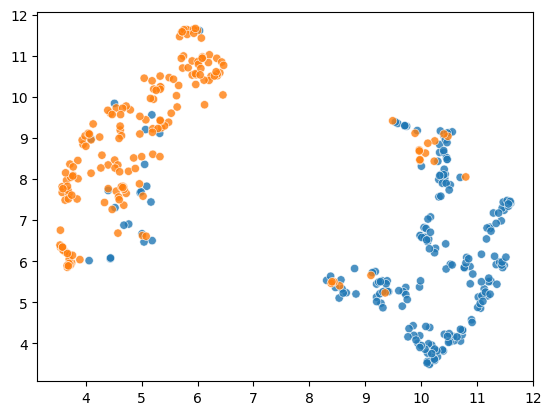

In [48]:
sn.scatterplot(x=embedding_head[:,0], y=embedding_head[:,1], hue=descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Head']['Sex'], alpha=0.8, legend=False)

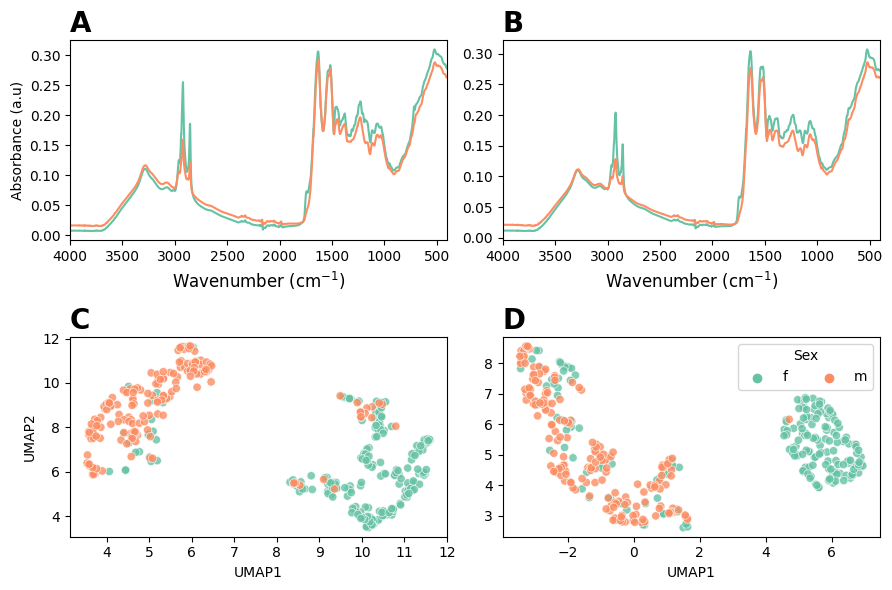

In [54]:
fig, ((ax2, ax3),(ax5, ax6)) = plt.subplots(2,2, figsize=(9,6))

sn.set_palette("Set2")
sn.scatterplot(x=embedding_head[:,0], y=embedding_head[:,1],ax=ax5, hue=descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Head']['Sex'], alpha=0.8, legend=False)

sn.scatterplot(x=embedding_thorax[:,0], y=embedding_thorax[:,1],ax=ax6, hue=descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Thorax']['Sex'], alpha=0.8)
ax6.legend(ncol=2, title='Sex')

y_labels = descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Head']['Sex']

for i, c in zip(np.unique(y_labels), colors):
    sn.lineplot(x=waveNums, y=np.mean(tsetse_head[y_labels == i], axis=0), label=i, color=c,ax=ax2, legend=False)

ax2.set_xlim(4000,401)
ax2.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax2.set_ylabel("Absorbance (a.u)")



y_labels = descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Thorax']['Sex']
for i, c in zip(np.unique(y_labels), colors):
    sn.lineplot(x=waveNums, y=np.mean(tsetse_thorax[y_labels == i], axis=0), label=i, color=c,ax=ax3, legend=False)

ax3.set_xlim(4000,401)
ax3.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)

ax5.set_xlabel("UMAP1")
ax5.set_ylabel('UMAP2')
ax6.set_xlabel("UMAP1")



labeles = ["A", "B", "C", "D", "E", "F"]
axes = fig.get_axes()
for a, l in zip(axes, labeles):
    a.set_title(l, loc='left', fontsize=20, fontweight='bold')




plt.tight_layout()

plt.savefig("../results/plots/PCA_sex.png", dpi=900)

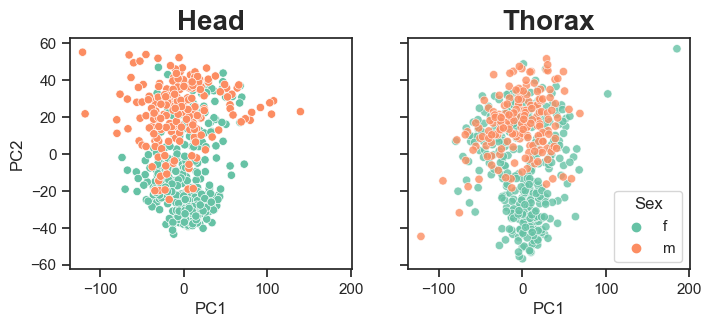

In [208]:
# PCA suplementary

fig, (ax,ax2) = plt.subplots(1,2, figsize=(8,3), sharey=True, sharex=True)
sn.scatterplot(x=X_pca_head[:,0], y=X_pca_head[:,1], hue=descriptorsDF[descriptorsDF['Tissue'] == 'Head']['Sex'], ax=ax, legend=False)

sn.scatterplot(x=X_pca_thorax[:,0], y=X_pca_thorax[:,1],ax=ax2, hue=descriptorsDF[descriptorsDF['Tissue'] == 'Thorax']['Sex'], alpha=0.8)

labeles = ["Head", "Thorax", "C", "D", "E", "F"]
axes = fig.get_axes()
for a, l in zip(axes, labeles):
    a.set_title(l, loc='center', fontsize=20, fontweight='bold')

ax.set_xlabel('PC1')
ax.set_ylabel("PC2")

ax2.set_xlabel('PC1')

plt.savefig("../results/plots/PCA_Suplementarysex.png", dpi=300)


## Sex prediction

In [12]:
tsetse_thorax = tsetse_data_copy.loc[descriptorsDF['Tissue'] == 'Thorax']
tsetse_head = tsetse_data_copy.loc[descriptorsDF['Tissue'] == 'Head']

In [13]:
tsetse_head.groupby("Sex")["ID"].count()

Sex
f    345
m    187
Name: ID, dtype: int64

In [24]:
X_thorax = tsetse_thorax.loc[:,"4000":"402"]
y_thorax = tsetse_thorax.loc[:,"Sex"]

X_head = tsetse_head.loc[:,"4000":"402"]
y_head = tsetse_head.loc[:,"Sex"]

In [ ]:
# permutation test

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

clf = SVC(kernel="linear", random_state=7)
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    clf, X_thorax, y_thorax, scoring="accuracy", cv=cv, n_permutations=1000)

fig, ax = plt.subplots()

ax.hist(perm_scores_iris, bins=20, density=True)
ax.axvline(score_iris, ls="--", color="r")
score_label = f"Score on original\ndata: {score_iris:.2f}\n(p-value: {pvalue_iris:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")

In [81]:
X_thorax.to_csv("../data/processed/X_thorax.csv", index=False)
y_thorax.to_csv("../data/processed/y_thorax_sex.csv", index=False)

In [25]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [26]:
thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [27]:
data_plot_thorax = dataplotmelt(thorax_acc_baseline)
data_plot_head = dataplotmelt(head_acc_baseline)

In [38]:
# test head

y_head_pred, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train)
y_thorax_pred, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train)

In [36]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.9719626168224299
Accuracy on test set: 0.9166666666666666


In [45]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head

,precision,recall,f1-score,support
f,0.962025,1.000000,0.980645,76.000000
m,1.000000,0.903226,0.949153,31.000000
accuracy,0.971963,0.971963,0.971963,0.971963
macro avg,0.981013,0.951613,0.964899,107.000000
weighted avg,0.973027,0.971963,0.971521,107.000000


In [51]:
report_head.to_excel("../results/tables/accuracy_sex_head.xlsx")

In [46]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax

,precision,recall,f1-score,support
f,0.957143,0.917808,0.937063,73.000000
m,0.842105,0.914286,0.876712,35.000000
accuracy,0.916667,0.916667,0.916667,0.916667
macro avg,0.899624,0.916047,0.906888,108.000000
weighted avg,0.919862,0.916667,0.917505,108.000000


In [52]:
report_thorax.to_excel("../results/tables/accuracy_sex_thorax.xlsx")

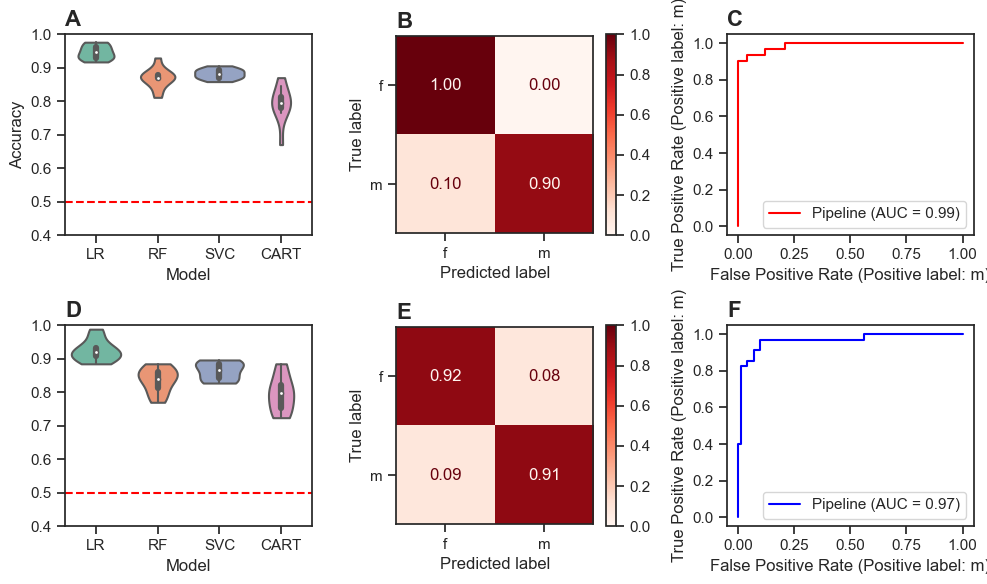

In [209]:
fig, ((ax,ax2, ax5),(ax3,ax4, ax6)) = plt.subplots(2,3,figsize=(10,6))
sn.violinplot(data=data_plot_head, x='param_clf',y='value',ax=ax, cut=0)
sn.violinplot(data=data_plot_thorax, x='param_clf', y='value', cut=0,ax=ax3)
ax.set_xlabel("Model")
ax.set_ylabel('Accuracy')
ax.set_ylim(0.4,1)
ax3.set_ylim(0.4,1)
ax.axhline(0.5, color='r',ls="--")
ax3.axhline(0.5, color='r',ls="--")
ax3.set_ylabel('')
ax3.set_xlabel("Model")


disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


RocCurveDisplay.from_estimator(pipe_head, X=X_hd_test, y=y_hd_test, ax=ax5, color='r')

RocCurveDisplay.from_estimator(pipe_thorax, X=X_th_test, y=y_th_test, ax=ax6, color='b')

sizeletters = 16
ax.set_title("A", loc='left', weight='bold',size=sizeletters)
ax2.set_title("B", loc='left', weight='bold', size=sizeletters)
ax3.set_title("D", loc='left', weight='bold', size=sizeletters)
ax4.set_title("E", loc='left', weight='bold', size=sizeletters)
ax5.set_title("C", loc='left', weight='bold', size=sizeletters)
ax6.set_title("F", loc='left', weight='bold', size=sizeletters)

plt.tight_layout()

plt.savefig("../results/plots/sex_prediction.png", dpi=300)


## Nested cross validation

In [82]:
X_thorax_nested = pd.read_csv("../data/processed/X_thorax.csv")
y_thorax_nested = pd.read_csv("../data/processed/y_thorax_sex.csv")

In [102]:
lb = LabelBinarizer()
y_thorax_encoded = lb.fit_transform(y_thorax)

In [133]:
cm_nested_th, y_pred_nested_th, y_test_nested_th, nested_accuracy =  nested_crossvalidation(X_thorax, y_thorax_encoded.ravel())

Acc=0.981, auc-roc=0.980, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=1.000, auc-roc=0.978, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=0.944, auc-roc=0.983, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.963, auc-roc=0.977, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.963, auc-roc=0.985, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.981, auc-roc=0.981, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=1.000, auc-roc=0.981, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.944, auc-roc=0.975, cfg={'model__C': 10, 'model__solver': 'newton-cg'}
Acc=0.907, auc-roc=0.984, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=0.887, auc-roc=0.988, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Mean accuracy: 0.96 (0.04)


In [107]:
lb = LabelBinarizer()
y_head_encoded = lb.fit_transform(y_head)

In [137]:
cm_nested_head, y_pred_nested_head, y_test_nested_head, accuracy_nested_head =  nested_crossvalidation(X_head, y_head_encoded.ravel())

Acc=0.944, auc-roc=0.988, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=0.907, auc-roc=0.993, cfg={'model__C': 100, 'model__solver': 'lbfgs'}
Acc=0.981, auc-roc=0.990, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.962, auc-roc=0.990, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=0.962, auc-roc=0.991, cfg={'model__C': 10, 'model__solver': 'liblinear'}
Acc=0.962, auc-roc=0.990, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.981, auc-roc=0.989, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.962, auc-roc=0.990, cfg={'model__C': 100, 'model__solver': 'liblinear'}
Acc=0.962, auc-roc=0.994, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Acc=0.981, auc-roc=0.989, cfg={'model__C': 100, 'model__solver': 'newton-cg'}
Mean accuracy: 0.96 (0.02)


In [151]:
accuracies_nested = pd.DataFrame({'head':accuracy_nested_head, 'thorax': nested_accuracy})

In [153]:
accuracies_nested_melt = pd.melt(accuracies_nested)
accuracies_nested_melt

,variable,value
0,head,0.944444
1,head,0.907407
2,head,0.981132
3,head,0.962264
4,head,0.962264
5,head,0.962264
6,head,0.981132
7,head,0.962264
8,head,0.962264
9,head,0.981132


Mean AUC = 0.987 (0.009)
Mean AUC = 0.981 (0.017)


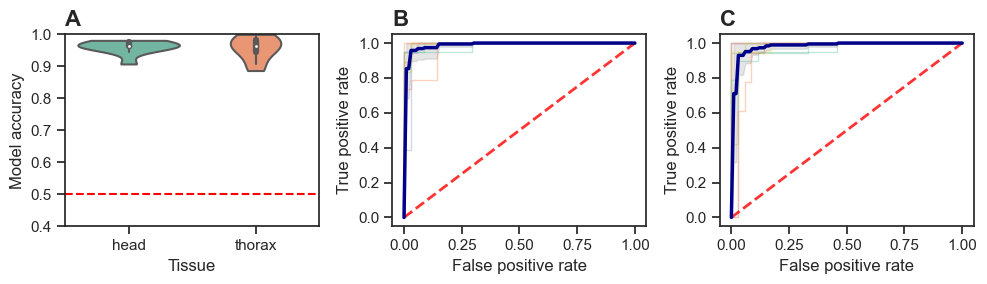

In [175]:
sn.set_context('notebook',font_scale=1)

fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
sn.violinplot(accuracies_nested_melt, x='variable', y='value', ax=ax, cut=0)
ax.set_xlabel("Tissue")
ax.set_ylabel("Model accuracy")
ax.set_ylim(0.4,1)
ax.axhline(0.5, color='r', ls='--')

nested_ROC_plot(y_test_nested_head, y_pred_nested_head, ax=ax2)
nested_ROC_plot(y_test_nested_th, y_pred_nested_th, ax=ax3)

ax.set_title("A", loc='left', weight='bold',size=sizeletters)
ax2.set_title("B", loc='left', weight='bold',size=sizeletters)
ax3.set_title("C", loc='left', weight='bold',size=sizeletters)

plt.tight_layout()

plt.savefig("../results/plots/BOX_ROC_nested_sex.png",dpi=900)

## Coefficients